In [2]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

class AbstractPortfolioGenerator:
    def __init__(self, n_decisions=5, n_objectives=2, n_aux=2):
        self.n_dec = n_decisions
        self.n_obj = n_objectives
        self.n_aux = n_aux

        # Generate generic names (decA, decB... objA, objB... auxA...)
        self.dec_names = [f"dec{string.ascii_uppercase[i]}" for i in range(n_decisions)]
        self.obj_names = [f"obj{string.ascii_uppercase[i]}" for i in range(n_objectives)]
        self.aux_names = [f"aux{string.ascii_uppercase[i]}" for i in range(n_aux)]

        # Random coefficients for Auxiliary metrics
        # This simulates a linear relationship between decisions and aux metrics
        self.aux_weights = np.random.rand(n_aux, n_decisions)

    def _dtlz2_objectives(self, X):
        """Calculates DTLZ2 objectives (Spherical Front)."""
        n_samples = X.shape[0]
        objs = np.zeros((n_samples, self.n_obj))

        # Split variables: k = position vars, rest = distance vars (g)
        k = self.n_obj - 1
        X_pos = X[:, :k]
        X_g = X[:, k:]

        # g(x) calculation
        g = np.sum((X_g - 0.5)**2, axis=1)

        # Objective calculations
        for i in range(self.n_obj):
            f = (1 + g)
            for j in range(self.n_obj - 1 - i):
                f *= np.cos(X_pos[:, j] * np.pi / 2)
            if i > 0:
                f *= np.sin(X_pos[:, self.n_obj - 1 - i] * np.pi / 2)
            objs[:, i] = f

        return objs

    def generate(self, n_samples=1000, dec_constraints=None, obj_constraints=None):
        # 1. Sample Decision Space (Dirichlet for Sum=1)
        alpha = np.ones(self.n_dec)
        dec_data = np.random.dirichlet(alpha, n_samples)

        # 2. Calculate Objectives
        obj_data = self._dtlz2_objectives(dec_data)

        # 3. Calculate Aux Metrics
        aux_data = np.dot(dec_data, self.aux_weights.T)

        # Combine
        df = pd.DataFrame(
            np.hstack([dec_data, obj_data, aux_data]),
            columns=self.dec_names + self.obj_names + self.aux_names
        )

        # 4. Apply Constraints
        if dec_constraints:
            for constr in dec_constraints:
                df = df[df.apply(constr, axis=1)]

        if obj_constraints:
            for constr in obj_constraints:
                df = df[df.apply(constr, axis=1)]

        return df

In [3]:
# --- CONFIGURATION ---
N_SAMPLES = 5000
N_DECISIONS = 4  # e.g., Cash, Bonds, Stocks, Crypto
N_OBJECTIVES = 2 # e.g., Risk, Return
N_AUX = 2        # e.g., ESG Score, Liquidity

# Initialize
gen = AbstractPortfolioGenerator(
    n_decisions=N_DECISIONS,
    n_objectives=N_OBJECTIVES,
    n_aux=N_AUX
)

# --- CONSTRAINTS ---
# Define constraints using lambda functions based on column names.
# Example: 'decA' (first asset) must be less than 40%
decision_rules = [
    lambda r: r['decA'] < 0.40,
    # lambda r: r['decB'] > 0.10  # Uncomment to add more
]

# Example: 'objA' (first objective) must be less than 1.5
objective_rules = [
    lambda r: r['objA'] < 1.5
]

# Generate
df = gen.generate(
    n_samples=N_SAMPLES,
    dec_constraints=decision_rules,
    obj_constraints=objective_rules
)

print(f"Generated {len(df)} portfolios after constraints.")
df.head()

Generated 3864 portfolios after constraints.


,decA,decB,decC,decD,objA,objB,auxA,auxB
1,0.191653,0.103985,0.600894,0.103468,1.264689,0.392668,0.122042,0.306096
2,0.020830,0.025046,0.433371,0.520753,1.229793,0.040253,0.094447,0.499973
5,0.016206,0.056025,0.808949,0.118820,1.437396,0.036599,0.104797,0.258992
6,0.115075,0.118653,0.596876,0.169396,1.243514,0.227257,0.121522,0.342505
7,0.012274,0.200230,0.516209,0.271287,1.142222,0.022025,0.133879,0.433183


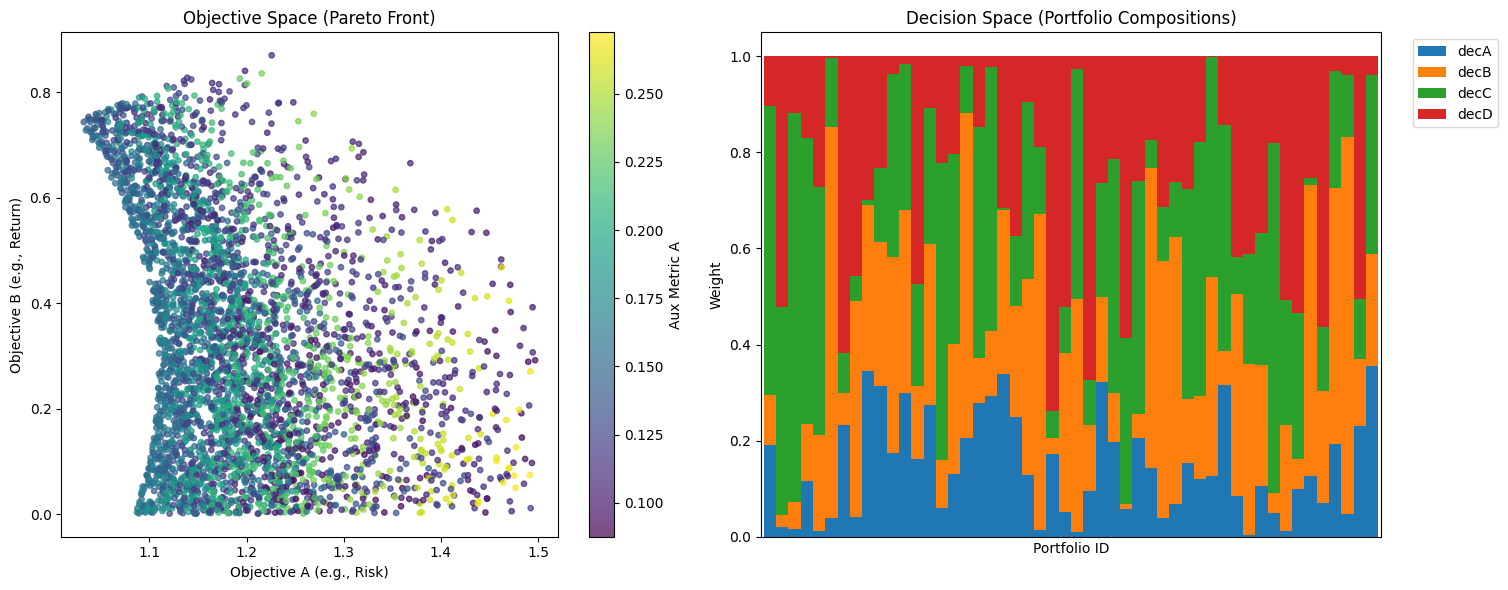

In [4]:
# Setup plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: The Pareto Front (Objective Space)
# X=objA, Y=objB, Color=auxA
sc = axes[0].scatter(df['objA'], df['objB'], c=df['auxA'], cmap='viridis', alpha=0.7, s=15)
axes[0].set_title('Objective Space (Pareto Front)')
axes[0].set_xlabel('Objective A (e.g., Risk)')
axes[0].set_ylabel('Objective B (e.g., Return)')
plt.colorbar(sc, ax=axes[0], label='Aux Metric A')

# Plot 2: Decision Space Composition (First 100 samples)
# Stacked bar chart to show portfolio composition
df.iloc[:50][gen.dec_names].plot(kind='bar', stacked=True, ax=axes[1], width=1.0)
axes[1].set_title('Decision Space (Portfolio Compositions)')
axes[1].set_xlabel('Portfolio ID')
axes[1].set_ylabel('Weight')
axes[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1))
axes[1].set_xticks([]) # Hide x-ticks for clarity

plt.tight_layout()
plt.show()